In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/CNN

Mounted at /content/gdrive
/content/gdrive/MyDrive/CNN


# 1.基本库的导入和随机种子的设定

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
np.random.seed(1234)

# 2.MINIST数据集的下载、保存与加载

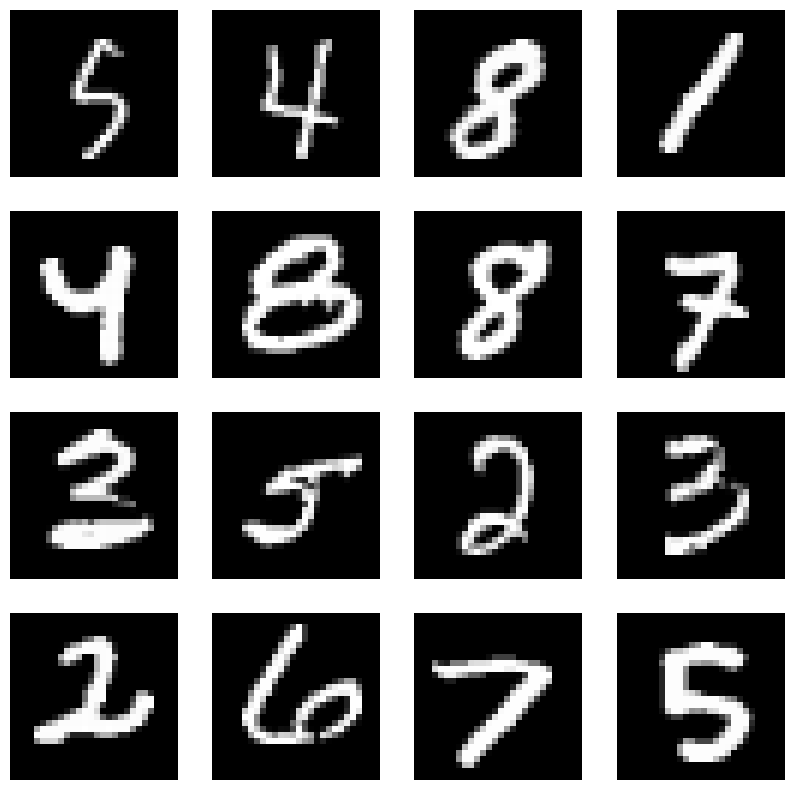

tensor([5, 4, 8, 1, 4, 8, 8, 7, 3, 5, 2, 3, 2, 6, 7, 5])


In [3]:
# 引用MNIST数据集,这里用的是torchvision已经封装好的MINST数据集
trainset = torchvision.datasets.MNIST(
    root='MNIST',  # root是下载MNIST数据集保存的路径，可以自行修改
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

testset = torchvision.datasets.MNIST(
    root='MNIST',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)
# 下载之后利用DataLoader实例化为适合遍历的训练集和测试集   batch_size一般设置较小的然后根据硬件条件逐渐增加
trainloader = DataLoader(dataset=trainset, batch_size=16,
                         shuffle=True)  # DataLoader是一个很好地能够帮助整理数据集的类，可以用来分批次，打乱以及多线程等操作
testloader = DataLoader(dataset=testset, batch_size=16, shuffle=True)

transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                                       ])
# 可视化某一批数据
train_img, train_label=next(iter(trainloader))   # iter迭代器，可以用来遍历trainloader里面每一个数据，这里只迭代一次来进行可视化
fig, axes = plt.subplots(4, 4, figsize=(10, 10)) #四行四列，16张图片
axes_list = []
# 输入到网络的图像
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i, j].imshow(train_img[i*4+j,0,:,:],cmap="gray") ##   # 这里画出来的就是我们想输入到网络里训练的图像，与之对应的标签用来进行最后分类结果损失函数的计算
        axes[i, j].axis("off")
# 对应的标签
plt.show() # 显示图像
print(train_label)


# 3.用pytorch搭建CNN

In [4]:
# 卷积模块，由卷积核和激活函数组成
class conv_block(nn.Module):
    def __init__(self,ks,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=ks,stride=1,padding=1,bias=True),  # 二维卷积核，用于提取局部的图像信息
            nn.ReLU(inplace=True), #这里用ReLU作为激活函数
            nn.Conv2d(ch_out, ch_out, kernel_size=ks,stride=1,padding=1,bias=True),
            nn.ReLU(inplace=True),
        )
    def forward(self,x):
        return self.conv(x)

# CNN的主体部分:由卷积模块和全连接组成。
class CNN(nn.Module):
    def __init__(self, kernel_size, in_ch, out_ch):
        super(CNN, self).__init__()
        feature_list = [16, 32, 64]  # 代表每一层网络的特征数，扩大特征空间有助于挖掘更多的局部信息
        self.conv1 = conv_block(kernel_size, in_ch, feature_list[0])
        self.conv2 = conv_block(kernel_size, feature_list[0], feature_list[1])
        self.conv3 = conv_block(kernel_size, feature_list[1], feature_list[2])
        self.fc = nn.Sequential(  # 全连接层主要用来进行分类，整合采集的局部信息以及全局信息
            nn.Linear(feature_list[2] * 28 * 28, 512),  # 此处28为MINST一张图片的维度
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        device = x.device
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x5 = x3.view(x3.size()[0], -1)  # 全连接层相当于做了矩阵乘法，所以这里需要将维度降维来实现矩阵的运算
        out = self.fc(x5)
        return out


# 4.训练CNN并保存损失最小的模型

epochs[  1/ 20] current loss: 0.19781, time: 59.847
epochs[  2/ 20] current loss: 0.04892, time: 60.349
epochs[  3/ 20] current loss: 0.03124, time: 58.338
epochs[  4/ 20] current loss: 0.01987, time: 58.885
epochs[  5/ 20] current loss: 0.01451, time: 58.965
epochs[  6/ 20] current loss: 0.00990, time: 58.654
epochs[  7/ 20] current loss: 0.00821, time: 58.443
epochs[  8/ 20] current loss: 0.00625, time: 58.608
epochs[  9/ 20] current loss: 0.00520, time: 58.341
epochs[ 10/ 20] current loss: 0.00369, time: 58.820
epochs[ 11/ 20] current loss: 0.00404, time: 58.260
epochs[ 12/ 20] current loss: 0.00336, time: 58.380
epochs[ 13/ 20] current loss: 0.00268, time: 58.384
epochs[ 14/ 20] current loss: 0.00257, time: 58.749
epochs[ 15/ 20] current loss: 0.00259, time: 58.365
epochs[ 16/ 20] current loss: 0.00151, time: 58.299
epochs[ 17/ 20] current loss: 0.00188, time: 58.384
epochs[ 18/ 20] current loss: 0.00210, time: 58.189
epochs[ 19/ 20] current loss: 0.00144, time: 58.512
epochs[ 20/ 

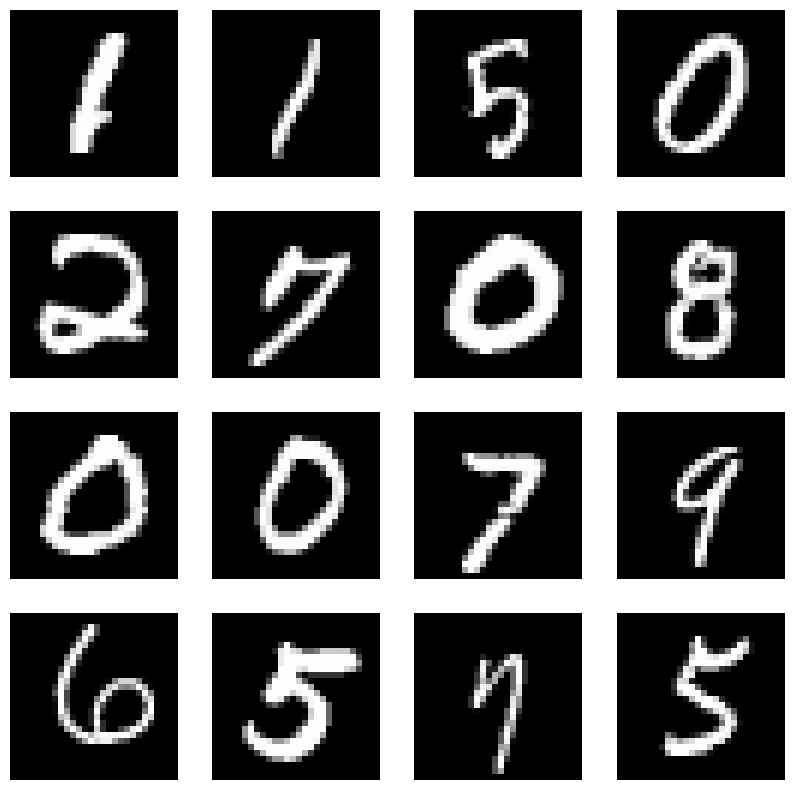

In [6]:
# 网络参数定义,包括优化器，迭代轮数，学习率，运行硬件等等的确定
device = torch.device("cuda")  #此处根据电脑配置进行选择，如果没有cuda就用cpu
#device = torch.device("cpu")
net = CNN(3,1,1).to(device = device,dtype = torch.float32)
epochs = 20  #训练轮次
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-8)  #使用Adam优化器
criterion = nn.CrossEntropyLoss()  #分类任务常用的交叉熵损失函数
train_loss = []

# Begin training 每一轮训练的主体
MinTrainLoss = 999
for epoch in range(1, epochs + 1):
    total_train_loss = []  # 存储当前epoch中每个batch的损失值
    net.train()   # 进入训练模式
    start = time.time()  # 记录当前时间
    for input_img, label in trainloader:
        input_img = input_img.to(device=device, dtype=torch.float32)  # 将取出来的训练集数据进行torch能够运算的格式转换
        label = label.to(device=device, dtype=torch.float32)  # 输入和输出的格式都保持一致才能进行运算
        optimizer.zero_grad()  # 每一次算loss前需要将之前的梯度清零，这样才不会影响后面的更新
        pred_img = net(input_img)
        loss = criterion(pred_img, label.long())  # 采用交叉熵损失函数计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 优化器进行下一次迭代
        total_train_loss.append(loss.item())
    train_loss.append(np.mean(total_train_loss))  # 将一个minibatch里面的损失取平均作为这一轮的loss
    end = time.time()
    # 打印当前的loss
    print(
        "epochs[%3d/%3d] current loss: %.5f, time: %.3f" % (epoch, epochs, train_loss[-1], (end - start)))  # 打印每一轮训练的结果
    # train_loss[-1]表示获取train_loss的最后一个元素，即当前epoch的平均损失
    if train_loss[-1] < MinTrainLoss:
        torch.save(net.state_dict(), "./model_min_train.pth")  # 保存loss最小的模型
        MinTrainLoss = train_loss[-1]

# 导入网络模型，输入某一批测试数据，查看结果
# 可视化测试集某一批数据
test_img,test_label=next(iter(testloader))
fig, axes = plt.subplots(4, 4, figsize=(10, 10))##
axes_list = []
#输入到网络的图像
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i, j].imshow(test_img[i*4+j,0,:,:],cmap="gray")##
        axes[i, j].axis("off")

# 预测我拿出来的那一批数据进行展示
cnn = CNN(3, 1, 1).to(device=device, dtype=torch.float32)
cnn.load_state_dict(torch.load("./model_min_train.pth", map_location=device))  # 导入我们之前已经训练好的模型
cnn.eval()  # 评估模式

test_img = test_img.to(device=device, dtype=torch.float32)
test_label = test_label.to(device=device, dtype=torch.float32)

pred_test = cnn(test_img)  # 记住，输出的结果是一个长度为10的tensor
test_pred = np.argmax(pred_test.cpu().data.numpy(), axis=1)  # 所以我们需要对其进行最大值对应索引的处理，从而得到我们想要的预测结果

# 预测结果以及标签
print("预测结果")
print(test_pred)
print("标签")
print(test_label.cpu().data.numpy())


In [ ]:
%cd /content/gdrive/MyDrive/
!zip -r CNN.zip CNN